## UFC Fight-level dataset SVM, SGD & NN Notebook
(thre is no quick rule as to which kernel performs best in every scenario; testing & learning is key)

Kernel trick reference:
https://towardsdatascience.com/understanding-support-vector-machine-part-2-kernel-trick-mercers-theorem-e1e6848c6c4d

#### Import necessary modules

In [34]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from keras.layers import Input, Lambda, Dense, Dropout
from keras.models import Model, Sequential
from keras import optimizers
from keras.optimizers import Adam, SGD, RMSprop, Adagrad, Nadam, Adamax, Adadelta
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 22})
%matplotlib inline

#### Helper functions

In [9]:
# rtns best params for C and Gamma; they are the parameters for a nonlinear support vector machine

def svc_parameter_optimization(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10] # C is trade off betw. low train error and low test error (ability to generalize) 
    gammas = [0.001, 0.01, 0.1, 1] # free parameter of the Gaussian radial basis function
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds) # instantiate grid search
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

#### Set working directory

In [10]:
os.chdir(r'/Users/colella2/Google Drive/Graduate School/MScA/Courses/31008 Data Mining Principles/Final_Project/msca31008/fun/')

In [11]:
pwd

'/Users/colella2/Google Drive/Graduate School/MScA/Courses/31008 Data Mining Principles/Final_Project/msca31008/fun'

In [12]:
os.listdir('../fun/') # confirm items in function folder

['.DS_Store',
 'r.py',
 'tonum.py',
 'hierarchical_imputation.py',
 'fillna-kmeans.py',
 'settings.py',
 'pkl.py',
 'spl.py',
 'untitled',
 'ddict.py']

In [13]:
exec(open('r.py').read()) # test ability to read .py script from function folder

In [14]:
# read-in all the functions
for filename in os.listdir('../fun/'):
    if filename.endswith('.py'):
        exec(open(filename).read())
        continue
    else:
        continue

#### Open file of interest

In [15]:
os.chdir(r'/Users/colella2/Google Drive/Graduate School/MScA/Courses/31008 Data Mining Principles/Final_Project/msca31008/out')

with open('d3-fight-level-transform.pkl', 'rb') as f:
    data = pickle.load(f)

In [16]:
load( '../out/d3-fight-level-transform.pkl' )
print( X.shape )

(4368, 165)


#### Examine key-value pairs in dict

In [17]:
for key, value in data.items():
  print(key, value)

X [[ 2.91491784e-01 -9.60590063e-02  2.50234064e-01 ... -7.94744912e-03
   3.10245107e-03 -1.87224280e-03]
 [ 2.70915901e-01 -1.24214845e-01  2.32611941e-01 ...  7.75837707e-03
   1.68645662e-03 -2.72968561e-04]
 [-9.60671224e-03 -1.16270731e-02 -9.73710726e-03 ... -2.94963859e-01
   6.74519642e-04  2.24984217e-04]
 ...
 [-1.24919035e-02 -1.80251541e-01 -1.85625621e-01 ... -1.63732606e-03
   2.16095113e-03 -1.86365288e-03]
 [-1.20995932e-02 -1.73834821e-01 -1.79162807e-01 ... -1.52725608e-04
   7.74126643e-04 -3.98965666e-04]
 [-1.29588989e-02 -1.83460266e-01 -1.89608127e-01 ... -2.01230682e-03
   1.44181940e-03 -1.33855060e-03]]
y 0       1
1       1
2       1
3       0
4       0
       ..
4363    1
4364    1
4365    1
4366    1
4367    1
Name: Winner, Length: 4368, dtype: int64
cols Index(['title_bout', 'weight_class', 'no_of_rounds', 'date_year', 'date_month', 'date_dayofmonth', 'date_dayofweek', 'date_frisat', 'womens', 'weight_class_catch_weight',
       ...
       'Mean_avg_opp_H

In [18]:
print(X.shape) # view feature shape; 4368 rows, 165 columns

(4368, 165)


In [19]:
print(y.shape) # view predicted value shape; 4368 rows, 1 column

(4368,)


#### Train-test split

In [20]:
X_train , X_test, y_train, y_test = train_test_split(X, y, random_state = 718, test_size = 0.3)

### SVM

#### Fit model (linear kernel)
(find decision boundary for linearly separable data)

In [14]:
svclassifier_linear = SVC(kernel='linear')
svclassifier_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [15]:
# accuracy against train data
print(classification_report(y_train,svclassifier_linear.predict(X_train)))

              precision    recall  f1-score   support

           0       0.61      0.16      0.26       981
           1       0.71      0.95      0.81      2076

    accuracy                           0.70      3057
   macro avg       0.66      0.56      0.53      3057
weighted avg       0.68      0.70      0.63      3057



In [16]:
# accuracy against test data
print(classification_report(y_test, svclassifier_linear.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.10      0.16       459
           1       0.66      0.94      0.78       852

    accuracy                           0.65      1311
   macro avg       0.57      0.52      0.47      1311
weighted avg       0.60      0.65      0.56      1311



In [17]:
# store predicted values on X_test & print confusion matrix
y_pred_linear = svclassifier_linear.predict(X_test)
print(confusion_matrix(y_test,y_pred_linear))

[[ 45 414]
 [ 47 805]]


### Begin section for non-linear investigation

#### Fit model (poly kernel)

In [18]:
svclassifier_poly = SVC(kernel='poly', degree=8)
svclassifier_poly.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=8, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [19]:
# accuracy against train data
print(classification_report(y_train,svclassifier_poly.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       981
           1       0.68      1.00      0.81      2076

    accuracy                           0.68      3057
   macro avg       0.34      0.50      0.40      3057
weighted avg       0.46      0.68      0.55      3057



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
# accuracy against test data
print(classification_report(y_test, svclassifier_poly.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.65      1.00      0.79       852

    accuracy                           0.65      1311
   macro avg       0.32      0.50      0.39      1311
weighted avg       0.42      0.65      0.51      1311



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [21]:
# store predicted values on X_test & print confusion matrix
y_pred_poly = svclassifier_poly.predict(X_test)
print(confusion_matrix(y_test,y_pred_poly))

[[  0 459]
 [  0 852]]


#### Fit model (Gaussian kernel)
(this is a special case for rbf)

In [22]:
svclassifier_gaus = SVC(kernel='rbf')
svclassifier_gaus.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [23]:
# accuracy against train data
print(classification_report(y_train,svclassifier_gaus.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       981
           1       0.68      1.00      0.81      2076

    accuracy                           0.68      3057
   macro avg       0.34      0.50      0.40      3057
weighted avg       0.46      0.68      0.55      3057



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
# accuracy against test data
print(classification_report(y_test, svclassifier_gaus.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.65      1.00      0.79       852

    accuracy                           0.65      1311
   macro avg       0.32      0.50      0.39      1311
weighted avg       0.42      0.65      0.51      1311



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
# store predicted values on X_test & print confusion matrix
y_pred_gaus = svclassifier_gaus.predict(X_test)
print(confusion_matrix(y_test,y_pred_gaus))

[[  0 459]
 [  0 852]]


#### After first running simply (as was done above), commence optimization...

In [26]:
# commence grid search for best parameters on training set
svc_parameter_optimization(X_train, y_train, 5)

{'C': 1, 'gamma': 1}

In [27]:
# instantiate with optimal parameters
svclassifier_gaus_optim = SVC(kernel='rbf', C = 1, gamma = 1)
svclassifier_gaus_optim.fit(X_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [28]:
# view optimized results/accuracy on training data
print(classification_report(y_train,svclassifier_gaus_optim.predict(X_train)))

              precision    recall  f1-score   support

           0       0.91      0.48      0.63       981
           1       0.80      0.98      0.88      2076

    accuracy                           0.82      3057
   macro avg       0.86      0.73      0.75      3057
weighted avg       0.84      0.82      0.80      3057



In [29]:
# view optimized results/accuracy on testing data
print(classification_report(y_test, svclassifier_gaus_optim.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.13      0.20       459
           1       0.66      0.92      0.77       852

    accuracy                           0.64      1311
   macro avg       0.57      0.53      0.49      1311
weighted avg       0.60      0.64      0.57      1311



In [30]:
# store predicted values on X_test & print confusion matrix
y_pred_gaus_optim = svclassifier_gaus_optim.predict(X_test)
print(confusion_matrix(y_test,y_pred_gaus_optim))

[[ 60 399]
 [ 67 785]]


#### Fit model (Sigmoid kernel)
(suitable for binary classification problems; rtns 0 or 1; activation functino for Neural Networks)

In [31]:
svclassifier_sig = SVC(kernel='sigmoid')
svclassifier_sig.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='sigmoid', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [32]:
# accuracy against train data
print(classification_report(y_train,svclassifier_sig.predict(X_train)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       981
           1       0.68      1.00      0.81      2076

    accuracy                           0.68      3057
   macro avg       0.34      0.50      0.40      3057
weighted avg       0.46      0.68      0.55      3057



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [33]:
# accuracy against test data
print(classification_report(y_test, svclassifier_sig.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       459
           1       0.65      1.00      0.79       852

    accuracy                           0.65      1311
   macro avg       0.32      0.50      0.39      1311
weighted avg       0.42      0.65      0.51      1311



/Users/colella2/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [34]:
# store predicted values on X_test & print confusion matrix
y_pred_sig = svclassifier_sig.predict(X_test)
print(confusion_matrix(y_test,y_pred_sig))

[[  0 459]
 [  0 852]]


#### Conclusion
Linear SVM performs similarly to optimized Gaussian RBF on test sets.

### SGD

In [35]:
# instantiate SGD classifier
linear_sgd_classifier = SGDClassifier(random_state = 0)

In [36]:
# instantiate the GridSearchCV object and run search
params = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 'loss':['hinge', 'log'], 'penalty':['l1','l2']}

grid_search = GridSearchCV(linear_sgd_classifier, params, cv = 5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5, random_state=0,
                                     shuffle=True, tol=0.001,
                                     validation_fraction=0.1, verbose=0,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'loss': ['hinge', 'log'], 'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, ret

In [37]:
# best parameters & the corresponding score
print("Best CV params", grid_search.best_params_)
print("Best CV accuracy", grid_search.best_score_)
print("Test accuracy of best grid search hypers:", grid_search.score(X_test, y_test))

Best CV params {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
Best CV accuracy 0.6810598626104023
Test accuracy of best grid search hypers: 0.6559877955758963


In [38]:
%%time

# fit SGD classifier
linear_sgd_classifier.fit(X_train, y_train)

CPU times: user 65.4 ms, sys: 981 µs, total: 66.3 ms
Wall time: 66.4 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=0, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
# accuracy against train data
print(classification_report(y_train, linear_sgd_classifier.predict(X_train)))

              precision    recall  f1-score   support

           0       0.61      0.32      0.42       981
           1       0.74      0.90      0.81      2076

    accuracy                           0.72      3057
   macro avg       0.67      0.61      0.62      3057
weighted avg       0.70      0.72      0.69      3057



In [40]:
# accuracy against test data
print(classification_report(y_test, linear_sgd_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.51      0.22      0.30       459
           1       0.68      0.88      0.77       852

    accuracy                           0.65      1311
   macro avg       0.59      0.55      0.54      1311
weighted avg       0.62      0.65      0.61      1311



As one can see, the accuracy on the test set is 0.65, matching Gaussian-RBD and linear SVM. It also better precision and recall than optimized Gaussian-RBF & matches of betters linear SVM. It matches linear SVM on recall.

### Neural Network
ReLu activation function for hidden layers.
Sigmoid activation function for binary classification. CAUTION: Large neural nets trained on relatively small datasets can overfit the training data. Generalization error increases due to overfitting.

#### Instance 1
3 layers of 55 nodes/neurons/perceptrons mapping to 1 target variable

In [41]:
# instantiate classifier
classifier = Sequential()

# optimal size of the hidden layer is usually between the size of the input and size of the output layers
# general rule I used was # input features of 165 / # hidden layers = # nodes per layer

# ReLu is based on principle that linear models are easier to optimize
# random normal initializer generates tensors with a normal distribution

# hidden layer 1 - # of neurons comprising this layer is equal to number of features
classifier.add(Dense(55, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 165))

# hidden layer 2
classifier.add(Dense(55, activation = 'relu', kernel_initializer = 'random_normal'))

# hidden layer 3
classifier.add(Dense(55, activation = 'relu', kernel_initializer = 'random_normal'))

# output layer
# single node for classification unless softmax is used -- then one node per class label
# Sigmoid function is the special case of Softmax function where the number of classes are 2
classifier.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

In [42]:
# compile NN
classifier.compile(optimizer = 'adam',loss = 'binary_crossentropy', metrics = ['accuracy'])

# use Adam optimization -- "adaptive moment estimation"; it's a combo of RMSProp + Momentum



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [43]:
%%time

# fit training data to model
# batch size 55 means 55 samples per gradient update AKA # of patterns shown to NN before weights updated
# also training optimization -- how many patterns to read at a time and keep in memory

# train w/ 60 epochs -- epoch is an iteration over entire data set
classifier.fit(X_train, y_train, batch_size = 55, epochs = 60)


Epoch 1/60
3057/3057 [==============================] - 1s 316us/step - loss: 0.6509 - acc: 0.6745
Epoch 2/60
3057/3057 [==============================] - 0s 43us/step - loss: 0.5880 - acc: 0.6791
Epoch 3/60
3057/3057 [==============================] - 0s 45us/step - loss: 0.5567 - acc: 0.6791
Epoch 4/60
3057/3057 [==============================] - 0s 48us/step - loss: 0.5389 - acc: 0.6991
Epoch 5/60
3057/3057 [==============================] - 0s 42us/step - loss: 0.5263 - acc: 0.7252
Epoch 6/60
3057/3057 [==============================] - 0s 45us/step - loss: 0.5116 - acc: 0.7406
Epoch 7/60
3057/3057 [==============================] - 0s 44us/step - loss: 0.4948 - acc: 0.7484
Epoch 8/60
3057/3057 [==============================] - 0s 46us/step - loss: 0.4716 - acc: 0.7723
Epoch 9/60
3057/3057 [==============================] - 0s 46us/step - loss: 0.4403 - acc: 0.7952
Epoch 10/60
3057/3057 [==============================] - 0s 45us/step - loss: 0.4005 - acc: 0.8240
Epoch 11/60
3057/

In [44]:
# evaluate loss & metrics values for model
classifier.evaluate(X_train, y_train) # accuracy near 100% on training data, which is a sign of overfitting

3057/3057 [==============================] - 0s 54us/step


[0.00195889087198293, 0.9996728819103696]

In [45]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [46]:
# accuracy on test: ~63%
confusion_matrix(y_test, y_pred) # TP + TN = 829; 829/1311 total = ~63% accurate

array([[154, 305],
       [185, 667]])

#### Instance 2
5 layers of 33 nodes mapping to 1 target variable

2 additional layers introduced b/c, empirically, deep NN's perform better

In [47]:
# instantiate classifier 2
classifier_2 = Sequential()

# hidden layer 1
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 165))

# hidden layer 2
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))

# hidden layer 3
classifier_2.add(Dense(33, activation ='relu', kernel_initializer = 'random_normal'))

# hidden layer 4
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))

# hidden layer 5
classifier_2.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))

# output layer
classifier_2.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

In [48]:
# compile NN
classifier_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [49]:
%%time

# fit training data to model
classifier_2.fit(X_train, y_train, batch_size = 15, epochs = 70)

Epoch 1/70
3057/3057 [==============================] - 2s 538us/step - loss: 0.6209 - acc: 0.6798
Epoch 2/70
3057/3057 [==============================] - 0s 144us/step - loss: 0.5574 - acc: 0.6791
Epoch 3/70
3057/3057 [==============================] - 0s 140us/step - loss: 0.5400 - acc: 0.7017
Epoch 4/70
3057/3057 [==============================] - 0s 142us/step - loss: 0.5264 - acc: 0.7138
Epoch 5/70
3057/3057 [==============================] - 0s 141us/step - loss: 0.5109 - acc: 0.7295
Epoch 6/70
3057/3057 [==============================] - 0s 142us/step - loss: 0.4947 - acc: 0.7488
Epoch 7/70
3057/3057 [==============================] - 0s 140us/step - loss: 0.4744 - acc: 0.7638
Epoch 8/70
3057/3057 [==============================] - 0s 141us/step - loss: 0.4516 - acc: 0.7851
Epoch 9/70
3057/3057 [==============================] - 0s 143us/step - loss: 0.4233 - acc: 0.8024
Epoch 10/70
3057/3057 [==============================] - 0s 141us/step - loss: 0.3821 - acc: 0.8306
Epoch 11/

In [50]:
# evaluate loss & metrics values for model
classifier_2.evaluate(X_train, y_train) # accuracy near 94% on training data, which is also a sign of overfitting

3057/3057 [==============================] - 0s 77us/step


[0.15603088445920044, 0.9453712790512282]

In [51]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred_2 = classifier_2.predict(X_test)
y_pred_2 = (y_pred_2 > 0.5)

In [52]:
# accuracy on test: ~63%
confusion_matrix(y_test, y_pred_2) # TP + TN = 802; 802/1311 total = ~63% accurate

array([[196, 263],
       [226, 626]])

#### Instance 3 -- tackle overfitting during model training
5 layers of 33 nodes mapping to 1 target variable

In [53]:
# instantiate classifier 3
classifier_3 = Sequential()

Implementation of dropout regularization to approximate training a large # of NN's w/ unique architectures in parallel, which we don't have the time or compute for.

In [54]:
# hidden layer 1
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 165))
classifier_3.add(Dropout(0.1))

# hidden layer 2
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# hidden layer 3
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# hidden layer 4
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# hidden layer 5
classifier_3.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_3.add(Dropout(0.1))

# output layer
classifier_3.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [55]:
# compile NN
classifier_3.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [56]:
%%time

# fit training data to model
classifier_3.fit(X_train,y_train, batch_size = 15, epochs = 60)

Epoch 1/60
3057/3057 [==============================] - 2s 744us/step - loss: 0.6295 - acc: 0.6781
Epoch 2/60
3057/3057 [==============================] - 1s 220us/step - loss: 0.5645 - acc: 0.6791
Epoch 3/60
3057/3057 [==============================] - 1s 213us/step - loss: 0.5369 - acc: 0.6791
Epoch 4/60
3057/3057 [==============================] - 1s 214us/step - loss: 0.5260 - acc: 0.6984
Epoch 5/60
3057/3057 [==============================] - 1s 216us/step - loss: 0.5126 - acc: 0.7216
Epoch 6/60
3057/3057 [==============================] - 1s 212us/step - loss: 0.4924 - acc: 0.7478
Epoch 7/60
3057/3057 [==============================] - 1s 214us/step - loss: 0.4712 - acc: 0.7573
Epoch 8/60
3057/3057 [==============================] - 1s 214us/step - loss: 0.4452 - acc: 0.7740
Epoch 9/60
3057/3057 [==============================] - 1s 213us/step - loss: 0.4164 - acc: 0.7959
Epoch 10/60
3057/3057 [==============================] - 1s 216us/step - loss: 0.4010 - acc: 0.8099
Epoch 11/

In [57]:
# evaluate loss & metrics values for model
classifier_3.evaluate(X_train, y_train) # accuracy near 94% on training data

3057/3057 [==============================] - 0s 121us/step


[0.11654213809834456, 0.9659797186979406]

In [58]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred_3 = classifier_3.predict(X_test)
y_pred_3 = (y_pred_3 > 0.5)

In [59]:
# accuracy on test: ~63%
confusion_matrix(y_test, y_pred_3) # TP + TN = 858; 858/1311 total = ~63% accurate

array([[176, 283],
       [199, 653]])

#### Instance 4
11 layers of 15 nodes mapping to 1 target variable

In [60]:
# instantiate classifier 4
classifier_4 = Sequential()

In [61]:
# hidden layer 1
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 165))
classifier_4.add(Dropout(0.1))

# hidden layer 2
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 3
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 4
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 5
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 6
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 7
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 8
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 9
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 10
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# hidden layer 11
classifier_4.add(Dense(15, activation = 'relu', kernel_initializer = 'random_normal'))
classifier_4.add(Dropout(0.1))

# output layer
classifier_4.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))

In [62]:
# compile NN
classifier_4.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [63]:
%%time

# fit training data to model
classifier_4.fit(X_train,y_train, batch_size = 15, epochs = 200)

Epoch 1/200
3057/3057 [==============================] - 4s 1ms/step - loss: 0.6533 - acc: 0.6768
Epoch 2/200
3057/3057 [==============================] - 1s 304us/step - loss: 0.6251 - acc: 0.6791
Epoch 3/200
3057/3057 [==============================] - 1s 308us/step - loss: 0.5800 - acc: 0.6791
Epoch 4/200
3057/3057 [==============================] - 1s 303us/step - loss: 0.5678 - acc: 0.6791
Epoch 5/200
3057/3057 [==============================] - 1s 308us/step - loss: 0.5569 - acc: 0.6791
Epoch 6/200
3057/3057 [==============================] - 1s 308us/step - loss: 0.5494 - acc: 0.6791
Epoch 7/200
3057/3057 [==============================] - 1s 311us/step - loss: 0.5450 - acc: 0.6791
Epoch 8/200
3057/3057 [==============================] - 1s 310us/step - loss: 0.5414 - acc: 0.6791
Epoch 9/200
3057/3057 [==============================] - 1s 307us/step - loss: 0.5358 - acc: 0.6791
Epoch 10/200
3057/3057 [==============================] - 1s 310us/step - loss: 0.5376 - acc: 0.6791
E

3057/3057 [==============================] - 1s 320us/step - loss: 0.4603 - acc: 0.6788
Epoch 83/200
3057/3057 [==============================] - 1s 318us/step - loss: 0.4574 - acc: 0.6807
Epoch 84/200
3057/3057 [==============================] - 1s 320us/step - loss: 0.4615 - acc: 0.6801
Epoch 85/200
3057/3057 [==============================] - 1s 318us/step - loss: 0.4513 - acc: 0.6801
Epoch 86/200
3057/3057 [==============================] - 1s 309us/step - loss: 0.4513 - acc: 0.6869
Epoch 87/200
3057/3057 [==============================] - 1s 314us/step - loss: 0.4534 - acc: 0.6883
Epoch 88/200
3057/3057 [==============================] - 1s 313us/step - loss: 0.4545 - acc: 0.6873
Epoch 89/200
3057/3057 [==============================] - 1s 316us/step - loss: 0.4563 - acc: 0.6876
Epoch 90/200
3057/3057 [==============================] - 1s 319us/step - loss: 0.4572 - acc: 0.6860
Epoch 91/200
3057/3057 [==============================] - 1s 320us/step - loss: 0.4575 - acc: 0.6869
Epo

3057/3057 [==============================] - 1s 319us/step - loss: 0.4389 - acc: 0.7072
Epoch 163/200
3057/3057 [==============================] - 1s 319us/step - loss: 0.4418 - acc: 0.7036
Epoch 164/200
3057/3057 [==============================] - 1s 320us/step - loss: 0.4369 - acc: 0.7085
Epoch 165/200
3057/3057 [==============================] - 1s 317us/step - loss: 0.4392 - acc: 0.7040
Epoch 166/200
3057/3057 [==============================] - 1s 310us/step - loss: 0.4398 - acc: 0.7082
Epoch 167/200
3057/3057 [==============================] - 1s 313us/step - loss: 0.4368 - acc: 0.7082
Epoch 168/200
3057/3057 [==============================] - 1s 315us/step - loss: 0.4400 - acc: 0.7069
Epoch 169/200
3057/3057 [==============================] - 1s 321us/step - loss: 0.4446 - acc: 0.7049
Epoch 170/200
3057/3057 [==============================] - 1s 320us/step - loss: 0.4371 - acc: 0.7102
Epoch 171/200
3057/3057 [==============================] - 1s 319us/step - loss: 0.4369 - acc: 0

In [64]:
# evaluate loss & metrics values for model
classifier_4.evaluate(X_train, y_train) # accuracy near 91% on training data

3057/3057 [==============================] - 1s 207us/step


[0.4251628810570916, 0.7167157344581022]

In [65]:
# predict on test data
# if prediction is greater than 0.5, output is 1; otherwise, output is 0
y_pred_4 = classifier_4.predict(X_test)
y_pred_4 = (y_pred_4 > 0.5)

In [66]:
# accuracy on test: ~XX%
confusion_matrix(y_test, y_pred_4) # TP + TN = XXX; XXX/1311 total = ~XX% accurate

array([[388,  71],
       [457, 395]])

#### Instance 5

Grid Search w/ Keras Classifier & 5-fold CV (Adam optimization)

In [67]:
# function to create model

def classifier_model():
    
    # create model
    model = Sequential()
    
    # hidden layer 1
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 165))
    model.add(Dropout(0.1))

    # hidden layer 2
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 3
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 4
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 5
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # output layer
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [68]:
# instantiate keras classifier model -- note that dropout is baked into the model
model = KerasClassifier(build_fn = classifier_model, verbose = 0)

In [69]:
# create grid search parameters

batches = [10, 15, 20, 25]
epochs = [25, 50, 100, 150, 200]

params = dict(batch_size = batches, epochs = epochs)

In [70]:
%%time

# instantiate the GridSearchCV object and run search
grid_search_2 = GridSearchCV(estimator = model, param_grid = params, n_jobs = -1, cv = 5)
grid_search_2_fit = grid_search_2.fit(X_train, y_train)

/Users/colella2/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


CPU times: user 17min 12s, sys: 2min 12s, total: 19min 25s
Wall time: 3h 2min 23s


In [71]:
# summarize results
# best_score is the mean cross-validated score of the best_estimator
print(grid_search_2_fit.best_score_, grid_search_2_fit.best_params_) # 68% model accuracy during train

0.6705921007442756 {'batch_size': 15, 'epochs': 200}


In [72]:
# instantiate model with best parameters as object for plotting
# get model history for plotting
history = model.fit(X_train, y_train, epochs = 200, batch_size = 20, validation_split = 0.2)

In [73]:
# extract metrics of value from model
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

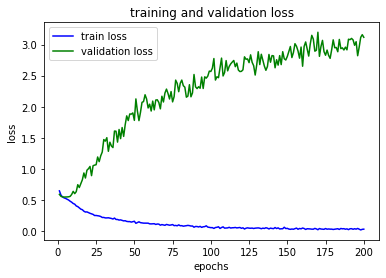

In [84]:
# plot loss & validation during training
plt.plot(epochs, loss, 'b', label = 'train loss')
plt.plot(epochs, val_loss, 'g', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Training loss decreases as expected with more epics. Near 200 epoachs, validation loss starts to stabalize, decreasing little by little.

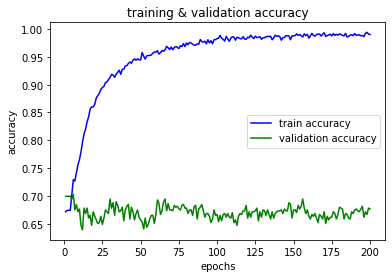

In [85]:
# plot accuracy during training
accuracy = history.history['acc']
valid_accuracy = history.history['val_acc']

plt.plot(epochs, accuracy, 'b', label = 'train accuracy')
plt.plot(epochs, valid_accuracy, 'g', label = 'validation accuracy')
plt.title('training & validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Training accuracy increases significantly as epics are added, starting to stabilize around 200 epochs. Validation accuracy dips and continues to increase little by little with more epics.

In [76]:
# evaluate NN on test set
grid_search_2_fit.score(X_test, y_test) # 64% accuracy during test -- model generalizes well

0.6407322829729906

The model generalizes well as there is only a 0.038 drop in accuracy from training to test.

#### Instance 6

Grid Search w/ Keras Classifier & 5-fold CV (SGD optimization)

In [26]:
# function to create model

def classifier_model2():
    
    # create model
    model = Sequential()
    
    # hidden layer 1
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal', input_dim = 165))
    model.add(Dropout(0.1))

    # hidden layer 2
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 3
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 4
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # hidden layer 5
    model.add(Dense(33, activation = 'relu', kernel_initializer = 'random_normal'))
    model.add(Dropout(0.1))

    # output layer
    model.add(Dense(1, activation = 'sigmoid', kernel_initializer = 'random_normal'))
    
    # specify optimization parameters
    sgd = optimizers.SGD(lr = 0.1) # no momentum is used by default
    
    # compile model
    model.compile(loss = 'binary_crossentropy', optimizer = sgd, metrics = ['accuracy'])
    
    return model

In [27]:
# instantiate keras classifier model -- note that dropout is baked into the model
model2 = KerasClassifier(build_fn = classifier_model2, verbose = 0)

In [28]:
# create grid search parameters

batches2 = [10, 15, 20, 25]
epochs2 = [25, 50, 100, 150, 200]

params2 = dict(batch_size = batches2, epochs = epochs2)

In [29]:
%%time

# instantiate the GridSearchCV object and run search
grid_search_3 = GridSearchCV(estimator = model2, param_grid = params2, n_jobs = -1, cv = 5)
grid_search_3_fit = grid_search_3.fit(X_train, y_train)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 58.5 s, sys: 6.78 s, total: 1min 5s
Wall time: 2h 19min 39s


In [30]:
# summarize results
# best_score is the mean cross-validated score of the best_estimator
print(grid_search_3_fit.best_score_, grid_search_3_fit.best_params_) # 68% model accuracy during train

0.6790971704019921 {'batch_size': 15, 'epochs': 25}


In [31]:
# instantiate model with best parameters as object for plotting
# get model history for plotting
history2 = model2.fit(X_train, y_train, epochs = 25, batch_size = 15, validation_split = 0.2)

In [32]:
# extract metrics of value from model
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epochs2 = range(1, len(loss2) + 1)

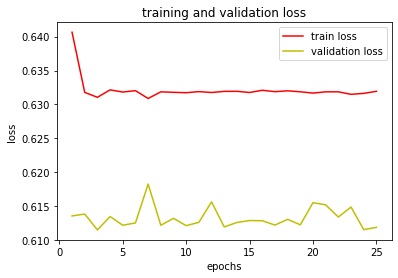

In [35]:
# plot loss & validation during training
plt.plot(epochs2, loss2, 'r', label = 'train loss')
plt.plot(epochs2, val_loss2, 'y', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Training loss decreases as expected with more epics. Near 200 epoachs, validation loss starts to stabalize.

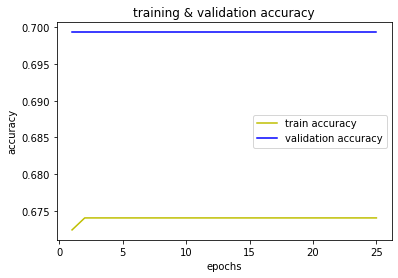

In [36]:
# plot accuracy during training
accuracy2 = history2.history['acc']
valid_accuracy2 = history2.history['val_acc']

plt.plot(epochs2, accuracy2, 'y', label = 'train accuracy')
plt.plot(epochs2, valid_accuracy2, 'b', label = 'validation accuracy')
plt.title('training & validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

Training accuracy increases around 3 epochs then remains relatively stable. Validation pretty consistent.

In [37]:
# evaluate NN on test set
grid_search_3_fit.score(X_test, y_test) # 65% accuracy during test -- model generalizes well

0.6498855994822504

The model generalizes well as there is only a 0.030 drop in accuracy from training to test. This slightly beats previous NN with Adam optimizer.